In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [14]:
import argparse
import copy
import csv
import decimal
import typing
from collections import Counter
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Set, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import simdjson as json
import skimage.io as io
from geo_llm_ret.fpref.ref_datasets import build_refcoco
from IPython.display import display
from pycocotools.coco import COCO
from pycocotools.helpers import CocoClassDistHelper

In [34]:
IMG_DIR = Path("/shared/gbiamby/data/coco/train2014")
REFSEG_DIR = Path("/shared/gbiamby/data/refer_seg")
dataset_name = "fprefcocog_v002"
split_by = "berkeley_exclude_unified"
refcoco = build_refcoco(REFSEG_DIR, dataset_name, split_by)

Loading refs from '/shared/gbiamby/data/refer_seg/fprefcocog_v002/refs(berkeley_exclude_unified).p'
Loaded 49822 refs
loading annotations into memory...
Done (t=5.96s)
creating index...
index created!


## Build Ref Stats DataFrame

In [38]:
def show_sentence_counts(coco: COCO, L=3, visualize=True):
    # print("Sentence counts for ", coco.)
    sentence_counts = Counter()
    counts = []
    anns_all = []
    for idx, ref in enumerate(coco.refs_data):
        sentences: list[dict] = ref["sentences"]
        count = len(sentences)
        sentence_counts.update({count: 1})
        counts.append(
            {
                "ref_id": ref["ref_id"],
                "image_id": ref["image_id"],
                "split": ref["split"] if "split" in ref else "",
                "ann_id": ref["ann_id"],
                "category_id": ref["category_id"],
                "category": coco.cats[ref["category_id"]]["name"],
                "supercategory": coco.cats[ref["category_id"]]["supercategory"]
                if "supercategory" in coco.cats[ref["category_id"]]
                else str(coco.cats[ref["category_id"]]),
                "sent_count": len(sentences),
                "pos_sent_count": len(
                    [
                        s
                        for s in sentences
                        if ("exist" in s and s["exist"]) or "exist" not in s
                    ]
                ),
                "neg_sent_count": len(
                    [s for s in sentences if ("exist" in s and not s["exist"])]
                ),
            }
        )
    # anns
    df_anns = pd.DataFrame(coco.anns.values())
    df_anns["category"] = df_anns.category_id.apply(
        lambda cat_id: coco.cats[cat_id]["name"]
    )
    if "segmentation" in df_anns.columns:
        df_anns = df_anns.drop(columns=["segmentation"])
    if "bbox" in df_anns.columns:
        df_anns = df_anns.drop(columns=["bbox"])

    # print(sentence_counts, len(sentence_counts))
    df = pd.DataFrame(counts)

    print("pos/neg sentence_counts: ", df.pos_sent_count.sum(), df.neg_sent_count.sum())
    df_agg = pd.DataFrame(
        df.groupby(lambda x: True).agg(
            num_refs=("ref_id", "count"),
            sent_count=("sent_count", "sum"),
            total_pos_sents=("pos_sent_count", "sum"),
            total_neg_sents=("neg_sent_count", "sum"),
        )
    )
    if visualize:
        display(df_agg)
    if L >= 1:
        df_agg = pd.DataFrame(
            df.groupby(["pos_sent_count"]).agg(
                num_refs=("ref_id", "count"),
                sent_count=("sent_count", "sum"),
                total_pos_sents=("pos_sent_count", "sum"),
                total_neg_sents=("neg_sent_count", "sum"),
            )
        )
        if visualize:
            display(df_agg)
    if L >= 2:
        df_agg = pd.DataFrame(
            df.groupby(["pos_sent_count", "neg_sent_count"]).agg(
                num_refs=("ref_id", "count"),
                sent_count=("sent_count", "sum"),
                total_pos_sents=("pos_sent_count", "sum"),
                total_neg_sents=("neg_sent_count", "sum"),
            )
        )
        if visualize:
            display(df_agg)
    # display(df_agg.droplevel(axis=0, level=0).reset_index(drop=True))
    return df, df_agg.reset_index(), df_anns

In [40]:
df_anns = []
df_refs = []
df_aggs = []

print("\n\n")
print("=" * 220)
print(f"Dataset: {dataset_name}({split_by})")

df_refcoco, df_refcoco_agg, df_ann = show_sentence_counts(refcoco, L=1, visualize=False)
# df_aggs
df_refcoco_agg["dataset"] = f"{dataset_name}({split_by})"
df_refcoco_agg["ann_count"] = len(refcoco.anns)
df_refcoco_agg["img_count"] = len(refcoco.imgs)
# Make 'dataset' the first column:
df_refcoco_agg.insert(0, "dataset", df_refcoco_agg.pop("dataset"))
df_aggs.append(df_refcoco_agg)

# df_refs
df_refcoco["dataset"] = f"{dataset_name}({split_by})"
df_refcoco.insert(0, "dataset", df_refcoco.pop("dataset"))
df_refs.append(df_refcoco)
# df_anns
df_ann["dataset"] = f"{dataset_name}({split_by})"
df_ann.insert(0, "dataset", df_ann.pop("dataset"))
df_anns.append(df_ann)


df_refs = pd.concat(df_refs)
df_aggs = pd.concat(df_aggs)
df_anns = pd.concat(df_anns)

display(df_anns)
display(df_refs)
display(df_aggs)




Dataset: fprefcocog_v002(berkeley_exclude_unified)
pos/neg sentence_counts:  95010 91240


dataset         area  iscrowd  \
0       fprefcocog_v002(berkeley_exclude_unified)  48667.84090        0   
1       fprefcocog_v002(berkeley_exclude_unified)  10501.20610        0   
2       fprefcocog_v002(berkeley_exclude_unified)   3110.01535        0   
3       fprefcocog_v002(berkeley_exclude_unified)     39.81120        0   
4       fprefcocog_v002(berkeley_exclude_unified)   6405.16950        0   
...                                           ...          ...      ...   
208955  fprefcocog_v002(berkeley_exclude_unified)    566.71230        0   
208956  fprefcocog_v002(berkeley_exclude_unified)    729.36245        0   
208957  fprefcocog_v002(berkeley_exclude_unified)  88909.53885        0   
208958  fprefcocog_v002(berkeley_exclude_unified)  59106.64675        0   
208959  fprefcocog_v002(berkeley_exclude_unified)  37887.19300        0   

        image_id  category_id       id  category  
0         131074           65   318235       bed  
1         131074           65   319598       bed  
2         131074           31  1174042   handbag  
3         131074           75  1630619    remote  
4         131074           65  1957252       bed  
...          ...          ...      ...       ...  
208955    393207            1  1202801    person  
208956    393207           31  1836790   handbag  
208957    524286           73  1099077    laptop  
208958    524286           76  1116665  keyboard  
208959    524286           76  1635174  keyboard  

[208960 rows x 7 columns]

dataset  ref_id  image_id  \
0      fprefcocog_v002(berkeley_exclude_unified)       0    546154   
1      fprefcocog_v002(berkeley_exclude_unified)       1    208256   
2      fprefcocog_v002(berkeley_exclude_unified)       2    307082   
3      fprefcocog_v002(berkeley_exclude_unified)       3    532439   
4      fprefcocog_v002(berkeley_exclude_unified)       4    155351   
...                                          ...     ...       ...   
49817  fprefcocog_v002(berkeley_exclude_unified)   49817    287303   
49818  fprefcocog_v002(berkeley_exclude_unified)   49818    355159   
49819  fprefcocog_v002(berkeley_exclude_unified)   49819    400744   
49820  fprefcocog_v002(berkeley_exclude_unified)   49820     82135   
49821  fprefcocog_v002(berkeley_exclude_unified)   49821    302415   

               split   ann_id  category_id  category supercategory  \
0              train   298801           32       tie     accessory   
1              train   453172            1    person        person   
2                val   401571            8     truck       vehicle   
3              train   584873           22  elephant        animal   
4              train  1154908           86      vase        indoor   
...              ...      ...          ...       ...           ...   
49817          train   135604            3       car       vehicle   
49818  train_exclude  2166645            1    person        person   
49819          train    56109           19     horse        animal   
49820          train   584687           22  elephant        animal   
49821  train_exclude  1735148            1    person        person   

       sent_count  pos_sent_count  neg_sent_count  
0               4               2               2  
1               4               2               2  
2               4               2               2  
3               4               2               2  
4               4               2               2  
...           ...             ...             ...  
49817           2               1               1  
49818           4               2               2  
49819           4               2               2  
49820           4               2               2  
49821           3               2               1  

[49822 rows x 11 columns]

dataset  pos_sent_count  num_refs  \
0  fprefcocog_v002(berkeley_exclude_unified)               1      4714   
1  fprefcocog_v002(berkeley_exclude_unified)               2     45028   
2  fprefcocog_v002(berkeley_exclude_unified)               3        80   

   sent_count  total_pos_sents  total_neg_sents  ann_count  img_count  
0        9185             4714             4471     208960      25799  
1      176596            90056            86540     208960      25799  
2         469              240              229     208960      25799

# Find Images with >= 2 different referents

In [61]:
del df_temp

In [63]:
df_imgs = pd.DataFrame(
    df_refs.groupby(["dataset", "image_id"]).agg(
        {
            "ref_id": ["count"],
            "category_id": [set],
            "category": ["count", "nunique", set],
            "pos_sent_count": ["sum", set],
            "neg_sent_count": ["sum", set],
        },
        as_index=False,
    )
).reset_index()
df_imgs.columns = [f"{x}_{y}" for x, y in df_imgs.columns.to_flat_index()]

display(
    df_imgs[df_imgs.category_nunique == 2].sort_values(
        "category_nunique", ascending=False
    )
)

dataset_  image_id_  ref_id_count  \
30     fprefcocog_v002(berkeley_exclude_unified)        735             2   
17313  fprefcocog_v002(berkeley_exclude_unified)     389280             5   
17222  fprefcocog_v002(berkeley_exclude_unified)     387513             2   
17237  fprefcocog_v002(berkeley_exclude_unified)     387769             4   
17238  fprefcocog_v002(berkeley_exclude_unified)     387812             4   
...                                          ...        ...           ...   
9067   fprefcocog_v002(berkeley_exclude_unified)     204792             4   
9069   fprefcocog_v002(berkeley_exclude_unified)     204837             3   
9070   fprefcocog_v002(berkeley_exclude_unified)     204863             3   
9072   fprefcocog_v002(berkeley_exclude_unified)     204962             3   
25787  fprefcocog_v002(berkeley_exclude_unified)     581670             3   

      category_id_set  category_count  category_nunique  \
30           {67, 61}               2                 2   
17313         {1, 67}               5                 2   
17222        {56, 57}               2                 2   
17237         {1, 31}               4                 2   
17238         {1, 42}               4                 2   
...               ...             ...               ...   
9067          {1, 20}               4                 2   
9069          {1, 62}               3                 2   
9070          {1, 15}               3                 2   
9072         {54, 47}               3                 2   
25787         {1, 54}               3                 2   

                 category_set  pos_sent_count_sum pos_sent_count_set  \
30       {cake, dining table}                   4                {2}   
17313  {dining table, person}                  10                {2}   
17222      {broccoli, carrot}                   4                {2}   
17237       {handbag, person}                   8                {2}   
17238     {surfboard, person}                   8                {2}   
...                       ...                 ...                ...   
9067          {sheep, person}                   8                {2}   
9069          {person, chair}                   6                {2}   
9070          {person, bench}                   6                {2}   
9072          {sandwich, cup}                   5             {1, 2}   
25787      {sandwich, person}                   6                {2}   

       neg_sent_count_sum neg_sent_count_set  
30                      4                {2}  
17313                  10                {2}  
17222                   4                {2}  
17237                   7             {1, 2}  
17238                   8                {2}  
...                   ...                ...  
9067                    8                {2}  
9069                    6                {2}  
9070                    6                {2}  
9072                    5             {1, 2}  
25787                   6                {2}  

[3457 rows x 11 columns]

<class 'int'> 156258
Displaying image: {'license': 5, 'file_name': 'COCO_train2014_000000156258.jpg', 'coco_url': 'http://mscoco.org/images/156258', 'height': 429, 'width': 640, 'date_captured': '2013-11-23 02:51:28', 'flickr_url': 'http://farm5.staticflickr.com/4032/4463888033_7a11894b09_z.jpg', 'id': 156258}
Img path:  /shared/gbiamby/data/coco/train2014/COCO_train2014_000000156258.jpg
Ann count:  4


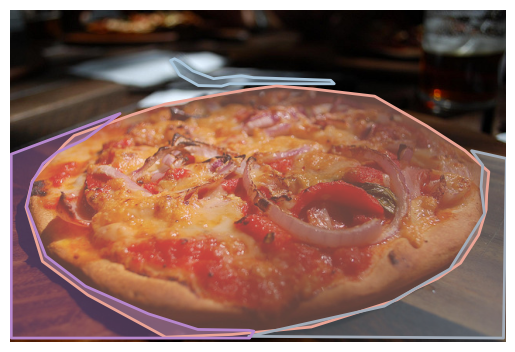

<class 'int'> 465229
Displaying image: {'license': 4, 'file_name': 'COCO_train2014_000000465229.jpg', 'coco_url': 'http://mscoco.org/images/465229', 'height': 480, 'width': 640, 'date_captured': '2013-11-21 20:24:43', 'flickr_url': 'http://farm1.staticflickr.com/219/451705012_b85b6444ae_z.jpg', 'id': 465229}
Img path:  /shared/gbiamby/data/coco/train2014/COCO_train2014_000000465229.jpg
Ann count:  4


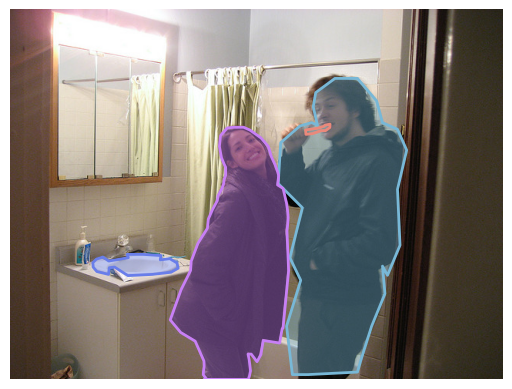

<class 'int'> 21075
Displaying image: {'license': 3, 'file_name': 'COCO_train2014_000000021075.jpg', 'coco_url': 'http://mscoco.org/images/21075', 'height': 496, 'width': 640, 'date_captured': '2013-11-20 19:30:51', 'flickr_url': 'http://farm3.staticflickr.com/2217/2038238491_7a8f1b4c5c_z.jpg', 'id': 21075}
Img path:  /shared/gbiamby/data/coco/train2014/COCO_train2014_000000021075.jpg
Ann count:  3


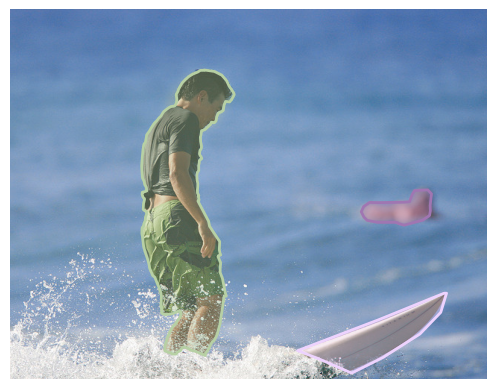

<class 'int'> 350069
Displaying image: {'license': 2, 'file_name': 'COCO_train2014_000000350069.jpg', 'coco_url': 'http://mscoco.org/images/350069', 'height': 426, 'width': 640, 'date_captured': '2013-11-19 22:55:42', 'flickr_url': 'http://farm6.staticflickr.com/5058/5570410100_47c9a02955_z.jpg', 'id': 350069}
Img path:  /shared/gbiamby/data/coco/train2014/COCO_train2014_000000350069.jpg
Ann count:  4


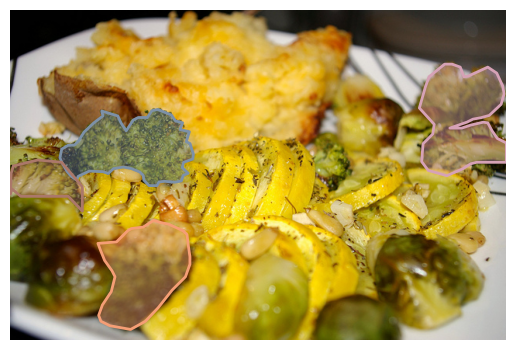

<class 'int'> 314708
Displaying image: {'license': 3, 'file_name': 'COCO_train2014_000000314708.jpg', 'coco_url': 'http://mscoco.org/images/314708', 'height': 556, 'width': 640, 'date_captured': '2013-11-17 16:29:11', 'flickr_url': 'http://farm9.staticflickr.com/8068/8238572936_c998939af9_z.jpg', 'id': 314708}
Img path:  /shared/gbiamby/data/coco/train2014/COCO_train2014_000000314708.jpg
Ann count:  18


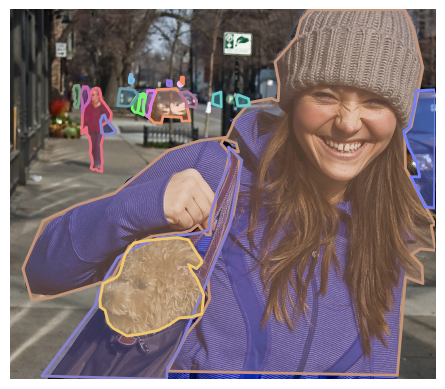

<class 'int'> 142497
Displaying image: {'license': 5, 'file_name': 'COCO_train2014_000000142497.jpg', 'coco_url': 'http://mscoco.org/images/142497', 'height': 480, 'width': 640, 'date_captured': '2013-11-24 07:36:26', 'flickr_url': 'http://farm1.staticflickr.com/164/344657457_f0390dce11_z.jpg', 'id': 142497}
Img path:  /shared/gbiamby/data/coco/train2014/COCO_train2014_000000142497.jpg
Ann count:  4


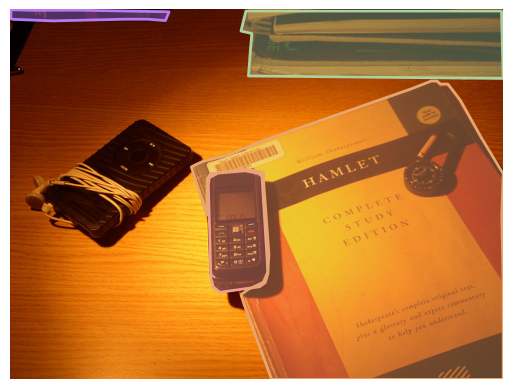

<class 'int'> 10900
Displaying image: {'license': 3, 'file_name': 'COCO_train2014_000000010900.jpg', 'coco_url': 'http://mscoco.org/images/10900', 'height': 427, 'width': 640, 'date_captured': '2013-11-19 21:49:03', 'flickr_url': 'http://farm4.staticflickr.com/3425/3745621573_29afe16a43_z.jpg', 'id': 10900}
Img path:  /shared/gbiamby/data/coco/train2014/COCO_train2014_000000010900.jpg
Ann count:  6


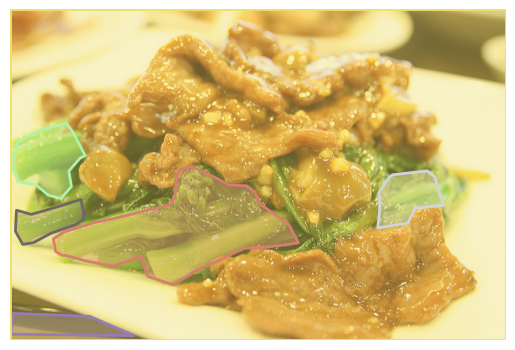

<class 'int'> 212095
Displaying image: {'license': 1, 'file_name': 'COCO_train2014_000000212095.jpg', 'coco_url': 'http://mscoco.org/images/212095', 'height': 480, 'width': 640, 'date_captured': '2013-11-20 18:30:30', 'flickr_url': 'http://farm4.staticflickr.com/3160/2695963569_fb375d36ea_z.jpg', 'id': 212095}
Img path:  /shared/gbiamby/data/coco/train2014/COCO_train2014_000000212095.jpg
Ann count:  3


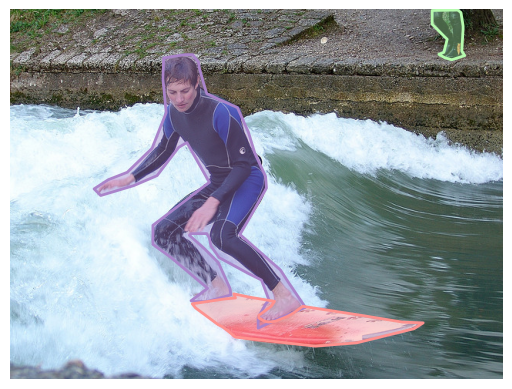

<class 'int'> 438855
Displaying image: {'license': 1, 'file_name': 'COCO_train2014_000000438855.jpg', 'coco_url': 'http://mscoco.org/images/438855', 'height': 640, 'width': 480, 'date_captured': '2013-11-15 17:29:12', 'flickr_url': 'http://farm4.staticflickr.com/3786/9405565469_abb8f268e5_z.jpg', 'id': 438855}
Img path:  /shared/gbiamby/data/coco/train2014/COCO_train2014_000000438855.jpg
Ann count:  18


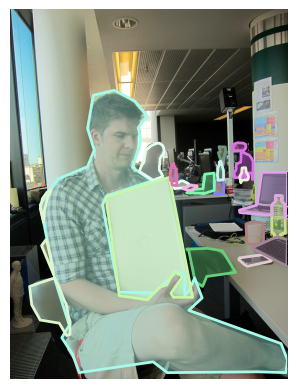

<class 'int'> 133905
Displaying image: {'license': 5, 'file_name': 'COCO_train2014_000000133905.jpg', 'coco_url': 'http://mscoco.org/images/133905', 'height': 427, 'width': 640, 'date_captured': '2013-11-20 21:33:30', 'flickr_url': 'http://farm4.staticflickr.com/3559/3596666923_c1f5f21147_z.jpg', 'id': 133905}
Img path:  /shared/gbiamby/data/coco/train2014/COCO_train2014_000000133905.jpg
Ann count:  7


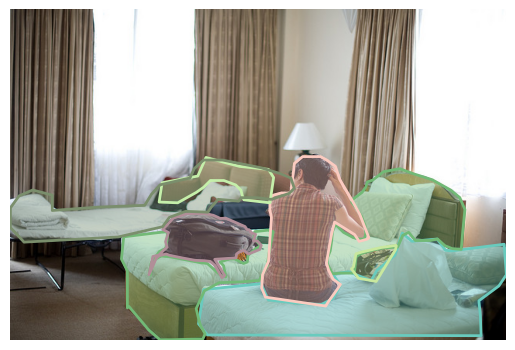

In [87]:
# load and display instance annotations (only for the specified cat_ids)
def show_coco_images(refcoco: COCO, img_ids: list[int], n: int):
    img_ids = np.random.choice(img_ids, n, replace=False).tolist()
    for img_id in img_ids:
        print(type(img_id), img_id)

        img = refcoco.loadImgs(img_id)[0]
        print(f"Displaying image: {img}")
        print("Img path: ", IMG_DIR / img["file_name"])
        I = io.imread(IMG_DIR / img["file_name"])
        plt.imshow(I)
        plt.axis("off")
        annIds = refcoco.getAnnIds(
            imgIds=img["id"],
        )
        anns = refcoco.loadAnns(annIds)
        print("Ann count: ", len(anns))
        refcoco.showAnns(anns)
        plt.show()
        plt.close()


# img_ids = list(refcoco.img_to_refs.keys())[:100]
img_ids = df_imgs.image_id_.values.tolist()
show_coco_images(refcoco, img_ids, n=10)

In [77]:
for ref in refcoco.img_to_refs[56359]:
    print(ref["ref_id"])
    print(ref["sent_ids"])
    print("ann_id: ", ref["ann_id"])
    for sent in ref["sentences"]:
        if sent["is_false_premise"]:
            print(sent["is_false_premise"], f"(parent: {sent['gt_sent_id']}), ", sent["sent"])
        else:
            print(sent["is_false_premise"], sent["sent"])
    print("")

9442
[10323, 10324]
ann_id:  581496
False an elephant walking calmly to the left of another elephant with it ' s mouth open
False elephant on left
True (parent: 10324),  giraffe on left

34950
[70026, 70027]
ann_id:  583084
False an elephant with its trunk up
False an elephant with its trunk in the air
True (parent: 70026),  an elephant with its tail up
True (parent: 70027),  an elephant with its trunk in the sky

38244
[77693, 77694]
ann_id:  459858
False a man in a green shirt to the right of another man in a green shirt
False the person on the elephant with its trunk up
True (parent: 77693),  a woman in a pink shirt to the right of another woman in a pink shirt
True (parent: 77694),  the person on the elephant with its trunk down



<class 'int'> 56359
Displaying image: {'license': 1, 'file_name': 'COCO_train2014_000000056359.jpg', 'coco_url': 'http://mscoco.org/images/56359', 'height': 480, 'width': 640, 'date_captured': '2013-11-18 06:43:56', 'flickr_url': 'http://farm7.staticflickr.com/6198/6113237130_2a68bf3b16_z.jpg', 'id': 56359}
Img path:  /shared/gbiamby/data/coco/train2014/COCO_train2014_000000056359.jpg
Ann count:  1


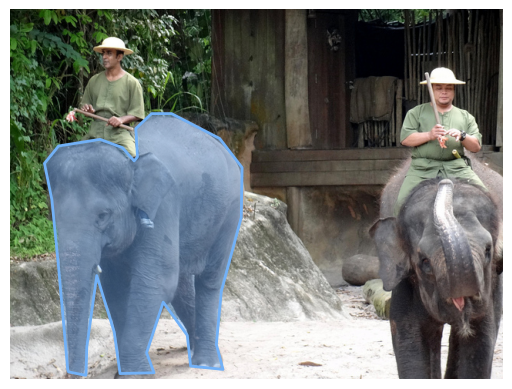

<class 'int'> 56359
Displaying image: {'license': 1, 'file_name': 'COCO_train2014_000000056359.jpg', 'coco_url': 'http://mscoco.org/images/56359', 'height': 480, 'width': 640, 'date_captured': '2013-11-18 06:43:56', 'flickr_url': 'http://farm7.staticflickr.com/6198/6113237130_2a68bf3b16_z.jpg', 'id': 56359}
Img path:  /shared/gbiamby/data/coco/train2014/COCO_train2014_000000056359.jpg


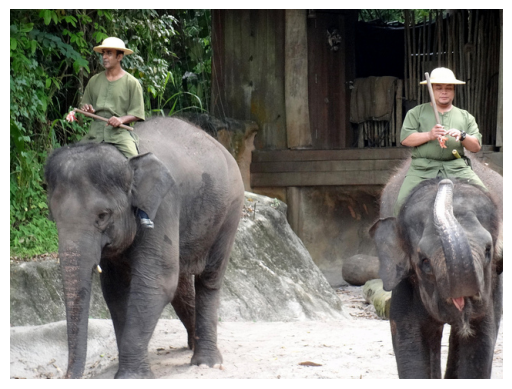

In [79]:
def show_image(refcoco: COCO, img_id: int, ann_id: int):

    print(type(img_id), img_id)

    img = refcoco.loadImgs(img_id)[0]
    print(f"Displaying image: {img}")
    print("Img path: ", IMG_DIR / img["file_name"])
    I = io.imread(IMG_DIR / img["file_name"])
    plt.imshow(I)
    plt.axis("off")
    if ann_id is not None:
        annIds = refcoco.getAnnIds(
            imgIds=img["id"],
        )
        annIds = [_ann_id for _ann_id in annIds if _ann_id == ann_id]
        anns = refcoco.loadAnns(annIds)
        print("Ann count: ", len(anns))
        refcoco.showAnns(anns)
    plt.show()
    plt.close()

show_image(refcoco, 56359, 581496)
show_image(refcoco, 56359, None)

<class 'int'> 56359
Displaying image: {'license': 1, 'file_name': 'COCO_train2014_000000056359.jpg', 'coco_url': 'http://mscoco.org/images/56359', 'height': 480, 'width': 640, 'date_captured': '2013-11-18 06:43:56', 'flickr_url': 'http://farm7.staticflickr.com/6198/6113237130_2a68bf3b16_z.jpg', 'id': 56359}
Img path:  /shared/gbiamby/data/coco/train2014/COCO_train2014_000000056359.jpg
Ann count:  4


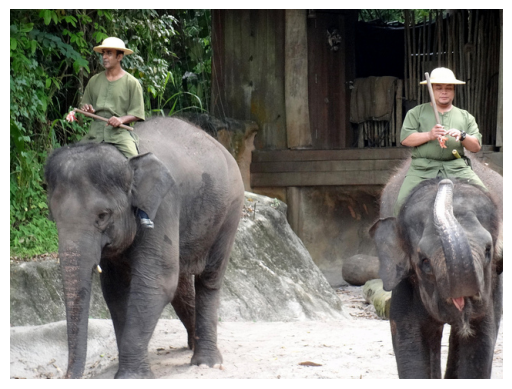

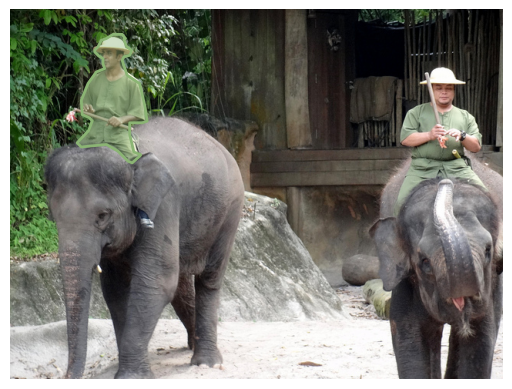

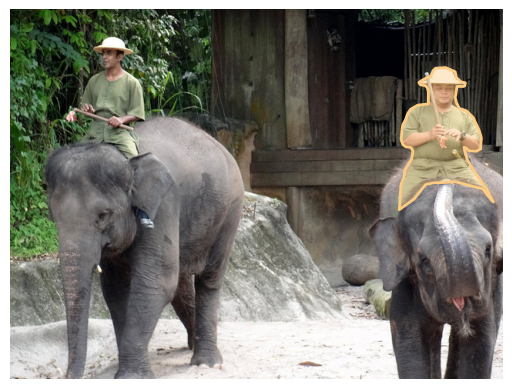

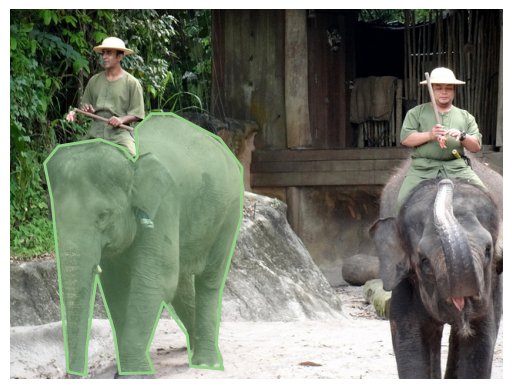

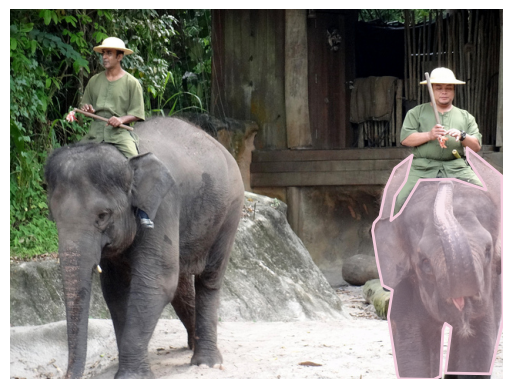

In [95]:

show_image(refcoco, 56359, None)

<class 'int'> 212095
Displaying image: {'license': 1, 'file_name': 'COCO_train2014_000000212095.jpg', 'coco_url': 'http://mscoco.org/images/212095', 'height': 480, 'width': 640, 'date_captured': '2013-11-20 18:30:30', 'flickr_url': 'http://farm4.staticflickr.com/3160/2695963569_fb375d36ea_z.jpg', 'id': 212095}
Img path:  /shared/gbiamby/data/coco/train2014/COCO_train2014_000000212095.jpg
Ann count:  3


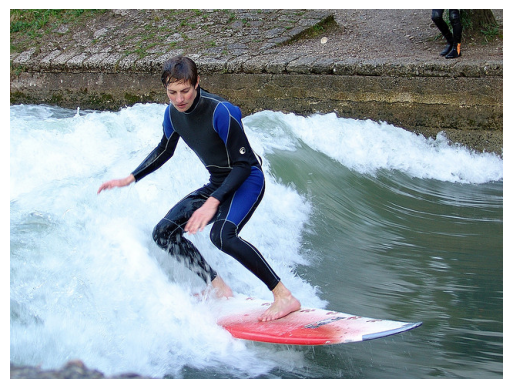

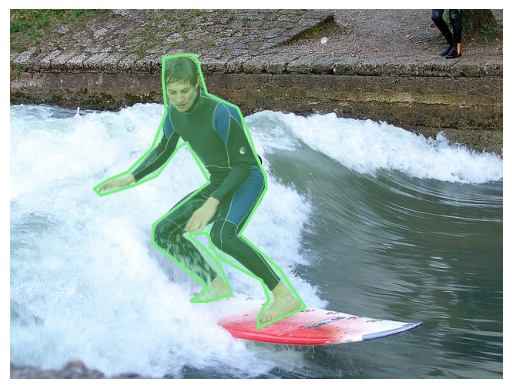

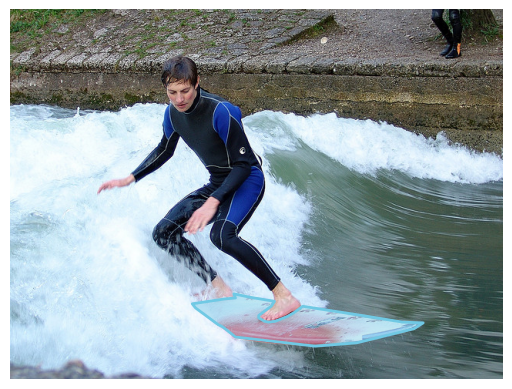

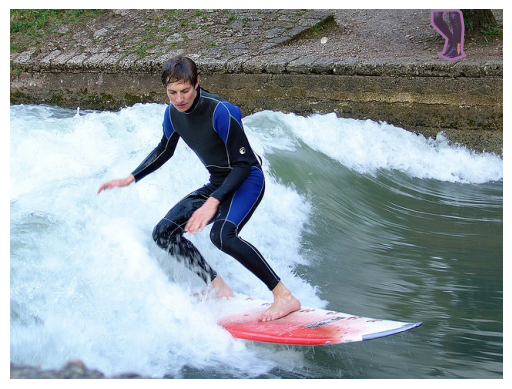

In [94]:
def show_image(refcoco: COCO, img_id: int, ann_id: int):

    print(type(img_id), img_id)

    img = refcoco.loadImgs(img_id)[0]
    print(f"Displaying image: {img}")
    print("Img path: ", IMG_DIR / img["file_name"])
    I = io.imread(IMG_DIR / img["file_name"])
    plt.imshow(I)
    plt.axis("off")
    if ann_id is not None:
        annIds = refcoco.getAnnIds(
            imgIds=img["id"],
        )
        annIds = [_ann_id for _ann_id in annIds if _ann_id == ann_id]
        anns = refcoco.loadAnns(annIds)
        print("Ann count: ", len(anns))
        refcoco.showAnns(anns)
    else:
        annIds = refcoco.getAnnIds(
            imgIds=img["id"],
        )
        anns = refcoco.loadAnns(annIds)
        print("Ann count: ", len(anns))
        
        plt.imshow(I)
        plt.axis("off")
        plt.show()
        plt.close()
        for ann in anns:
            
            plt.imshow(I)
            plt.axis("off")
            refcoco.showAnns([ann])
            plt.show()
            plt.close()
            

show_image(refcoco, 212095, None)

